In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import sys, os, importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [3]:
repo_paths = ['/home/simonealbanesi/repos/IPAM2021_ML/', '/home/simone/repos/IPAM2021_ML/', 
             '/Users/simonealbanesi/repos/IPAM2021_ML/']
for rp in repo_paths:
    if os.path.isdir(rp):
        repo_path = rp
        break
sys.path.insert(0, repo_path+'utils/')

In [4]:
import fancyplots as fp
import sklassyNN  as sknn
import errstats   as es
import errsurf
from split_GstLAL_data import split_GstLAL_data

## Input

In [5]:
hlayers_sizes   = (400,400)
seed            = 10
verbose_train   = True
epochs          = 10
batch_size      = 128
SNR_min         = 0 # used only in train-dataset

show_figs       = True
save_figs       = False

compact_bounds  = {}
#features2use    = 'mass&spin'
#compact_bounds['A'] = [0.75, -1, -1, 0.75]
#compact_bounds['B'] = [500,   1,  1,  130] # before MCD6 was [400,1,1,120]
features2use = 'm1m2chi1chi2'
compact_bounds['A'] = [0.75, 0.75, -1, -1]
compact_bounds['B'] = [500,   250,  1,  1]

learning_rate  = 0.001;

show_err_distr = False

# Warning 1: using out_interval=None is not equivalnt to linear_output=True!!
# Warning 2: using linear_output=True can produce unphysical prediction!

m1_cutoff = None
Mc_min    = None

data_path = repo_path+'datasets/GstLAL/'

show_errsurf = False
do_crossval  = False

save_model   = True
model_name   = "sklassyNN_m1m2chi1chi2"

## Load data

In [6]:
fname_train_data = data_path+'train_NS.csv'
fname_test_data  = data_path+'test_NS.csv'
train_datasets   = sknn.extract_data(fname_train_data, skip_header=True)
test_datasets    = sknn.extract_data(fname_test_data, skip_header=True)

#train_datasets  = shuffle(train_datasets)

--------------------------------------------------
Nsamples (tot): 139999
--------------------------------------------------


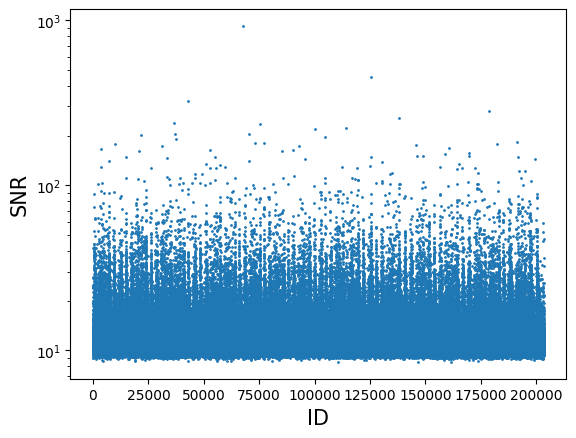

--------------------------------------------------  train  -------------------------------------------------


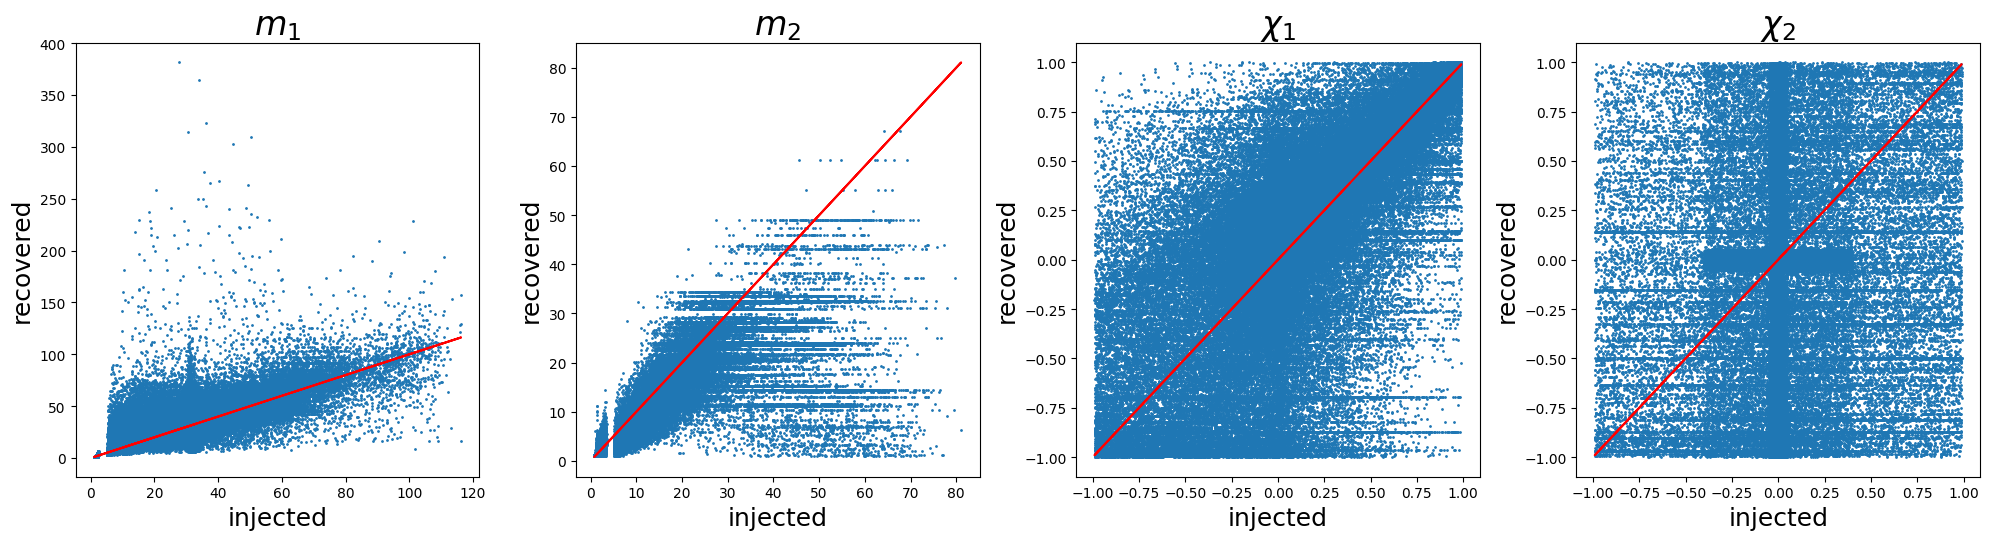

In [7]:
train_data_split = split_GstLAL_data(train_datasets, features=features2use, m1_cutoff=m1_cutoff, Mc_min=Mc_min)
train_inj = train_data_split['inj']
train_rec = train_data_split['rec']
train_snr = train_data_split['SNR']
train_ID  = train_data_split['ID']

print('-'*50)
print('Nsamples (tot):', len(train_snr))
print('-'*50)
if SNR_min>min(train_snr):
    rows2remove = []
    for i in range(len(train_snr)):
        snr = train_snr[i]
        if snr<SNR_min:
            rows2remove.append(i)
    train_inj = np.delete(train_inj, rows2remove, axis=0)
    train_rec = np.delete(train_rec, rows2remove, axis=0)
    train_snr = np.delete(train_snr, rows2remove, axis=0)
    train_ID  = np.delete(train_ID,  rows2remove, axis=0)
    print('SNR_min :', SNR_min)
    print('Nsamples:', len(train_snr))
    
test_data_split = split_GstLAL_data(test_datasets, features=features2use, m1_cutoff=m1_cutoff, Mc_min=Mc_min)
test_inj = test_data_split['inj']
test_rec = test_data_split['rec']
test_snr = test_data_split['SNR']

names     = train_data_split['names']
nfeatures = len(train_inj[0,:])
ntrain    = len(train_inj[:,0])
ntest     = len( test_inj[:,0])

plt.figure
plt.scatter(train_ID, train_snr, s=1)
plt.yscale('log')
plt.ylabel('SNR', fontsize=15)
plt.xlabel('ID', fontsize=15)
if save_figs:
    plt.savefig('snr.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()
    
print('-'*50,' train ','-'*49)
plt.figure(figsize=(20,10))
for i in range(nfeatures):
    ax = plt.subplot(241+i)
    ax.scatter(train_inj[:,i], train_rec[:,i],s=1)
    ax.plot(train_inj[:,i], train_inj[:,i], 'r')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel('injected', fontsize=18)
    ax.set_ylabel('recovered', fontsize=18)
plt.tight_layout()
if save_figs:
    plt.savefig('rec_vs_inj.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

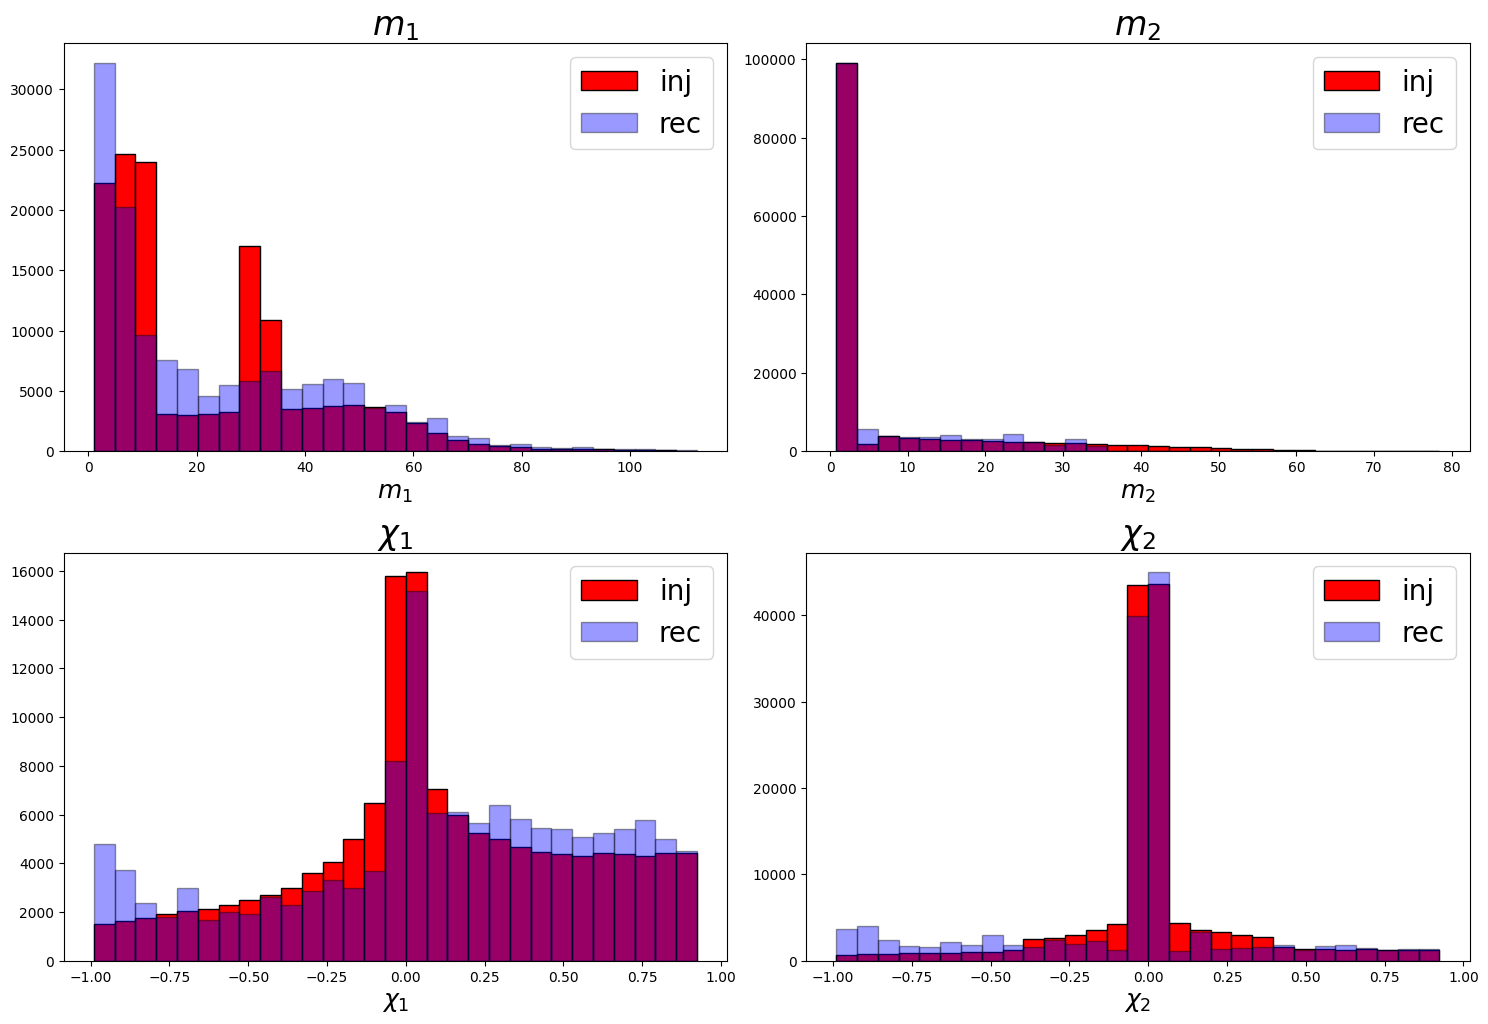

In [8]:
plt.figure(figsize=(15,20))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(4,2,i+1)
    fmin = min(train_inj[:,i])
    fmax = max(train_inj[:,i])
    fstep = (fmax-fmin)/nbins
    ax.hist(train_inj[:,i], bins=np.arange(fmin, fmax, fstep), alpha=1,   color=[1,0,0], label='inj', ec='black')
    ax.hist(train_rec[:,i], bins=np.arange(fmin, fmax, fstep), alpha=0.4, color=[0,0,1], label='rec', ec='black')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

In [9]:
NN = sknn.RegressionNN(hlayers_sizes=hlayers_sizes, seed=seed)

In [10]:
NN.load_train_dataset(xtrain_data=train_rec, ytrain_data=train_inj, 
                      verbose=False, compact_bounds=compact_bounds)


--------------------------------------------------------------------------------
feature n.1
--------------------------------------------------------------------------------


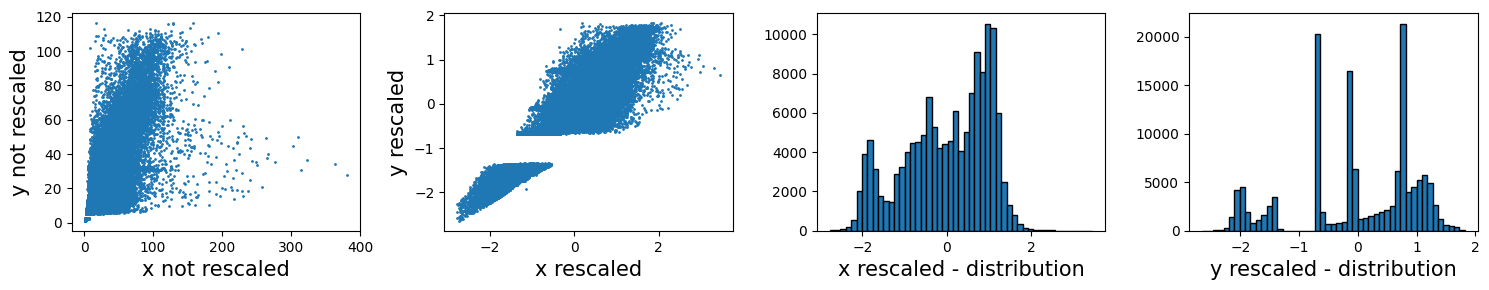

max diff check :  1.1368683772161603e-13
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.2
--------------------------------------------------------------------------------


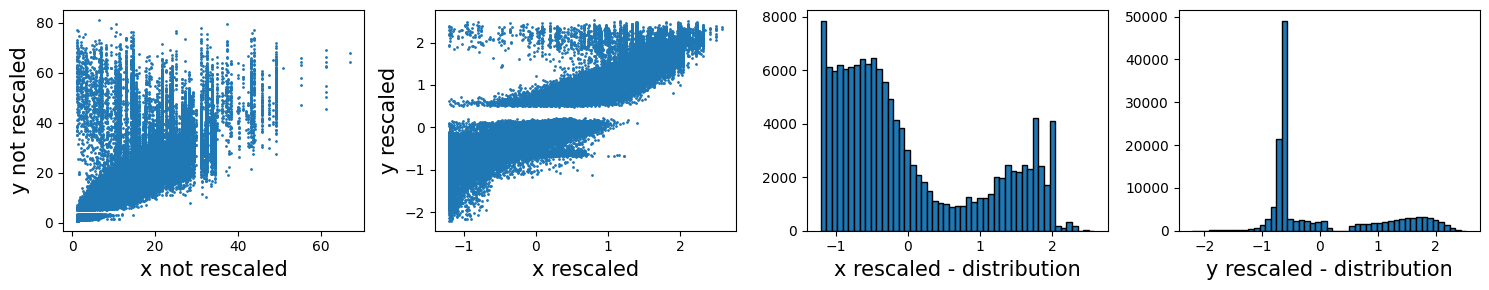

max diff check :  1.4210854715202004e-14
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.3
--------------------------------------------------------------------------------


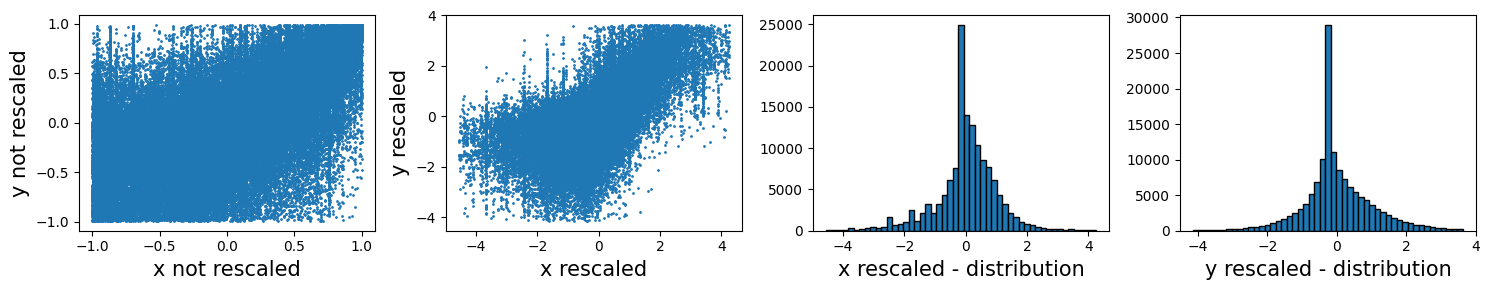

max diff check :  3.3306690738754696e-16
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.4
--------------------------------------------------------------------------------


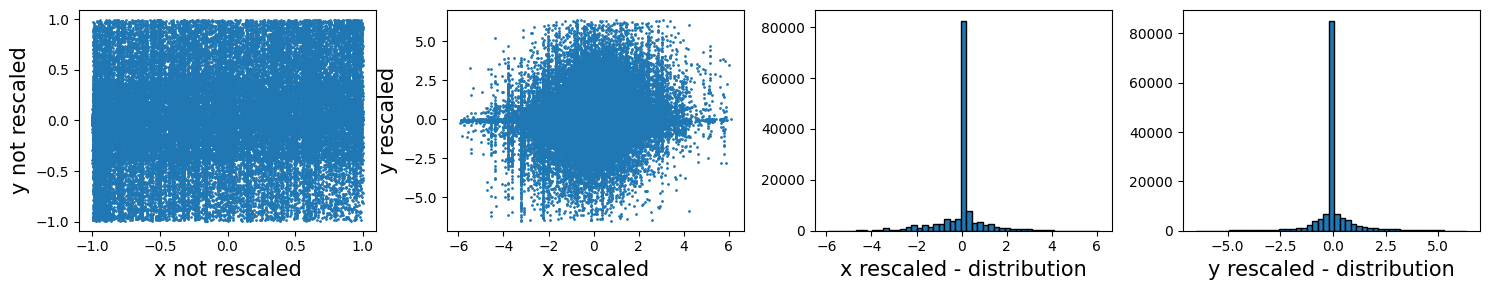

max diff check :  3.3306690738754696e-16
NaN found in Y :  0
NaN found in X1:  0 





In [11]:
X0 = NN.xtrain_notnorm
Y  = NN.scaler_x.transform(X0)
X1 = NN.scaler_x.inverse_transform(Y)

for i in range(NN.nfeatures):
    print('-'*80, 'feature n.'+str(i+1), '-'*80, sep='\n')
    plt.figure(figsize=(15,3))
    plt.subplot(141)
    plt.scatter(NN.xtrain_notnorm[:,i], NN.ytrain_notnorm[:,i], s=1)
    plt.xlabel('x not rescaled', fontsize=15)
    plt.ylabel('y not rescaled', fontsize=15)
    plt.subplot(142)
    plt.scatter(NN.xtrain[:,i], NN.ytrain[:,i], s=1)
    plt.xlabel('x rescaled', fontsize=15)
    plt.ylabel('y rescaled', fontsize=15)
    nan_counter_Y  = 0
    nan_counter_X1 = 0
    for j in range(len(Y[:,i])):
        y  =  Y[j,i]
        x1 = X1[j,i]
        if np.isnan(y):
            nan_counter_Y += 1
        if np.isnan(x1):
            nan_counter_X1 += 1
    if nan_counter_Y == 0:
        plt.subplot(143)
        x = NN.xtrain[:,i]
        plt.hist(x, bins=np.linspace(min(x), max(x), 50), histtype='bar', ec='black')
        #plt.hist(Y[:,i], bins=np.linspace(min(x), max(x), 50), alpha=0.5, histtype='bar', ec='black')
        plt.xlabel('x rescaled - distribution', fontsize=15)
        plt.subplot(144)
        y = NN.ytrain[:,i]
        plt.hist(y, bins=np.linspace(min(y), max(y), 50), histtype='bar', ec='black')
        plt.xlabel('y rescaled - distribution', fontsize=15)
    plt.tight_layout()
    if save_figs:
        plt.savefig('scaler_feature'+str(i)+'.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()
    diff = X1[:,i]-X0[:,i]
    print('max diff check : ', max(diff))
    print('NaN found in Y : ', nan_counter_Y)
    print('NaN found in X1: ', nan_counter_X1, '\n\n\n')

In [12]:
NN.training(epochs=epochs, batch_size=batch_size, verbose=verbose_train, learning_rate=learning_rate)

Iteration 1, loss = 0.16375613
Iteration 2, loss = 0.15658686
Iteration 3, loss = 0.15508118
Iteration 4, loss = 0.15420220
Iteration 5, loss = 0.15364395
Iteration 6, loss = 0.15318414
Iteration 7, loss = 0.15280417
Iteration 8, loss = 0.15244916
Iteration 9, loss = 0.15211451
Iteration 10, loss = 0.15180808


/Users/simonealbanesi/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
if save_model:
    NN.save_model(model_name=model_name, verbose=True, overwrite=True)

sklassyNN_m1m2chi1chi2 saved


In [14]:
print(NN.training_time)

91.568703375


In [15]:
NN.load_test_dataset(xtest_data=test_rec, ytest_data=test_inj, verbose=True)

In [16]:
print('-'*25, 'R2 for recovery', '-'*25)
def R2_numpy(y_true, y_pred):
            SS_res = np.sum((y_true - y_pred )**2)
            SS_tot = np.sum((y_true - np.mean(y_true))**2)
            return 1-SS_res/SS_tot
for i in range(nfeatures):
    R2 = R2_numpy(test_inj[:,i], test_rec[:,i])  
    print('R2[{:2d}]         : {:.5f}'.format(i,R2))

print('-'*25, 'R2 for prediction', '-'*23)
NN.print_metrics()

"""
print('-'*25, 'R2 for prediction, check', '-'*23)
test_pred = NN.compute_prediction(NN.xtest, transform_output=True)
for i in range(nfeatures):
    R2 = R2_numpy(test_inj[:,i], test_pred[:,i])  
    print('R2[{:2d}]         : {:.5f}'.format(i,R2))
""";

------------------------- R2 for recovery -------------------------
R2[ 0]         : 0.61870
R2[ 1]         : 0.66875
R2[ 2]         : 0.28814
R2[ 3]         : -1.56280
------------------------- R2 for prediction -----------------------
Final R2 mean  : 0.70420
R2[ 0]         : 0.96650
R2[ 1]         : 0.96723
R2[ 2]         : 0.74062
R2[ 3]         : 0.14242


## Histograms

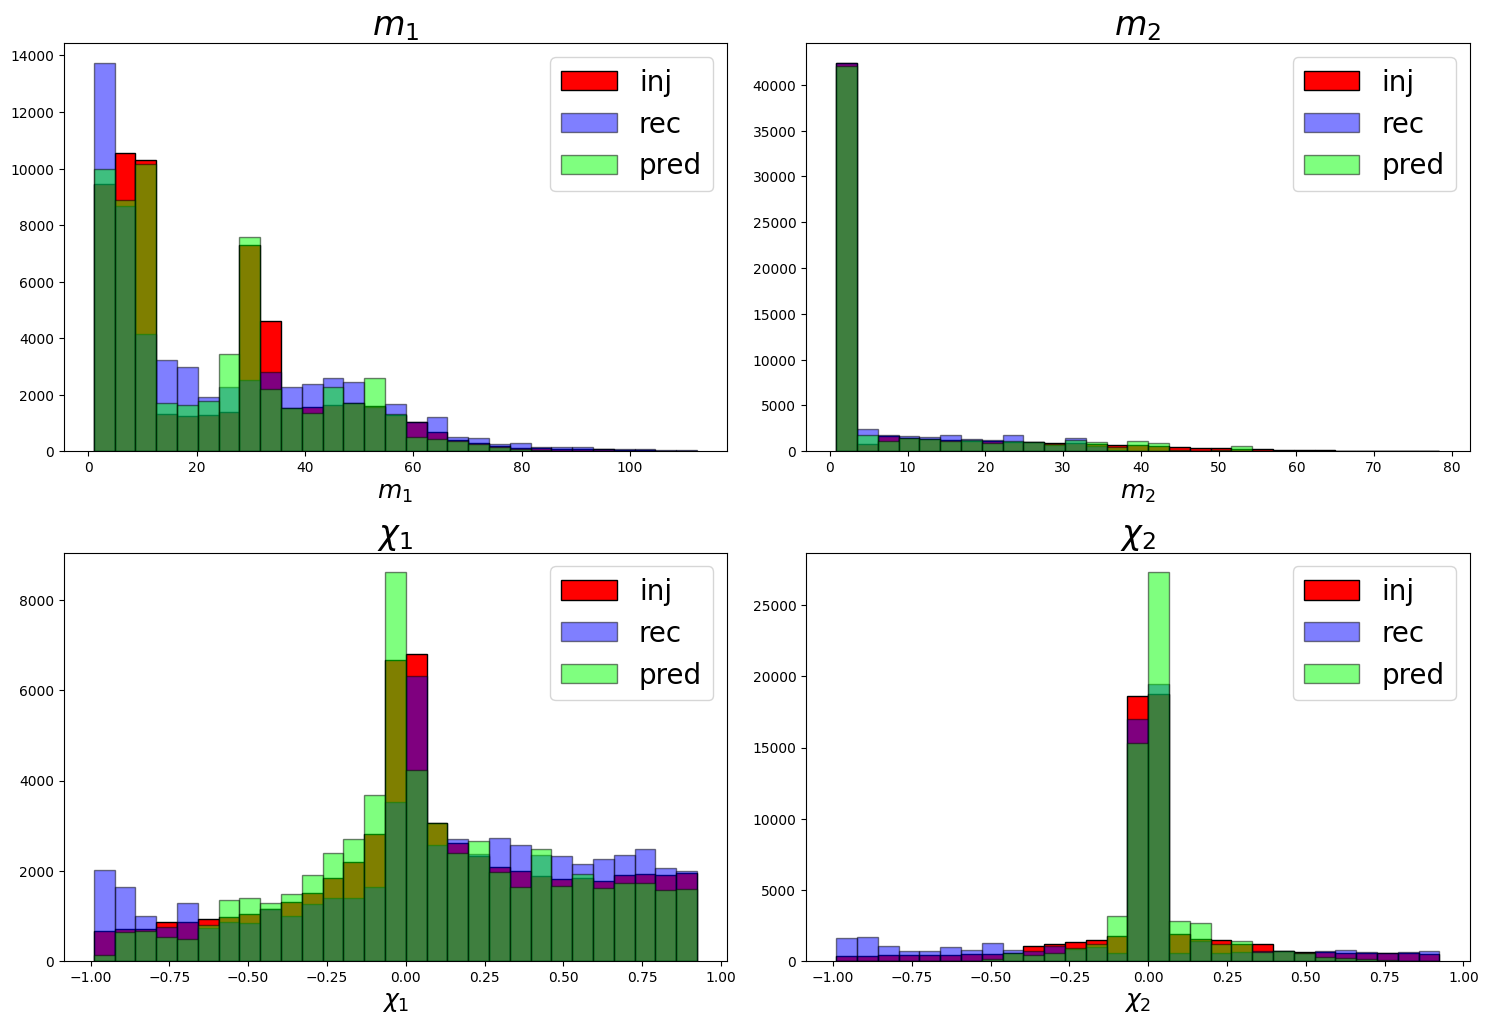

In [17]:
pred = NN.compute_prediction(NN.xtest, transform_output=True) # normalized prediction
plt.figure(figsize=(15,20))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(4,2,i+1)
    fmin = min(train_inj[:,i])
    fmax = max(train_inj[:,i])
    fstep = (fmax-fmin)/nbins
    ax.hist(test_inj[:,i], bins=np.arange(fmin, fmax, fstep), alpha=1,   color=[1,0,0], label='inj', ec='black')
    ax.hist(test_rec[:,i], bins=np.arange(fmin, fmax, fstep), alpha=0.5, color=[0,0,1], label='rec', ec='black')
    ax.hist( pred[:,i], bins=np.arange(fmin, fmax, fstep), alpha=0.5, color=[0,1,0], label='pred', ec='black')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr_wpred.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

------------------------------------------------ m1 --------------------------------------------------
mean rec   rel diff  :  -0.17166 (std= 0.58254, | rel diff |= 0.34841)
mean pred  rel diff  :  -0.02575 (std= 0.31028, | rel diff |= 0.14098)


median rec   rel diff  :  -0.08910
median pred  rel diff  :   0.01686


recovery   below fmin=-10.00: 8
recovery   above fmax=  2.00: 0
prediction below fmin=-10.00: 0
prediction above fmax=  2.00: 0


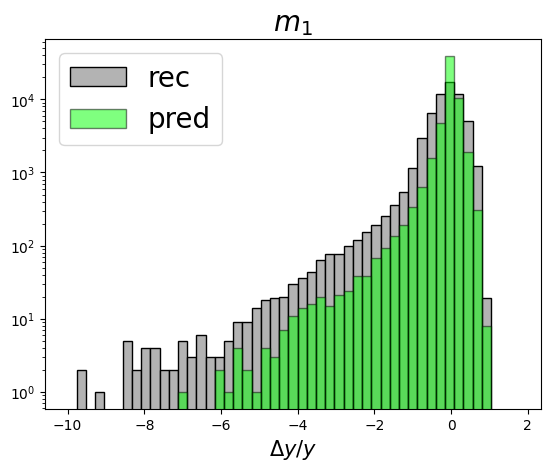

----------------------------------------------   m2 --------------------------------------------------
mean rec   rel diff  :   0.04959 (std= 0.36200, | rel diff |= 0.25570)
mean pred  rel diff  :  -0.03805 (std= 0.33420, | rel diff |= 0.12731)


median rec   rel diff  :   0.09662
median pred  rel diff  :  -0.02885


recovery   below fmin= -3.00: 7
recovery   above fmax=  1.70: 0
prediction below fmin= -3.00: 29
prediction above fmax=  1.70: 0


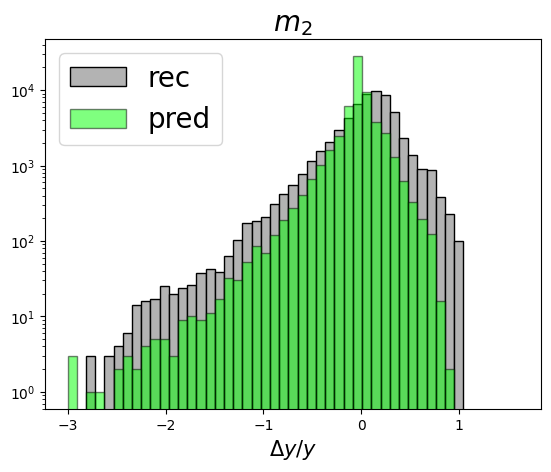

---------------------------------------------- chi1 --------------------------------------------------
mean rec  difference :  -0.00289 (std= 0.38856, |difference|= 0.26675)
mean pred difference :   0.01503 (std= 0.23978, |difference|= 0.14254)


median rec  difference :  -0.02098
median pred difference :   0.02428


recovery   below fmin= -1.70: 5
recovery   above fmax=  1.70: 28
prediction below fmin= -1.70: 0
prediction above fmax=  1.70: 0


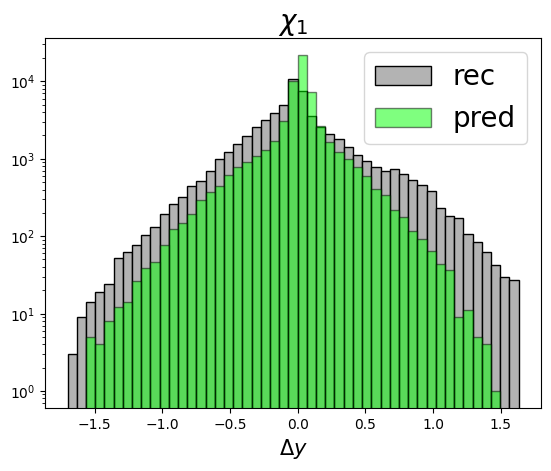

---------------------------------------------- chi2 --------------------------------------------------
mean rec  difference :   0.06589 (std= 0.45543, |difference|= 0.27354)
mean pred difference :  -0.00825 (std= 0.26748, |difference|= 0.15100)


median rec  difference :   0.00390
median pred difference :  -0.00672


recovery   below fmin= -1.70: 43
recovery   above fmax=  1.70: 162
prediction below fmin= -1.70: 0
prediction above fmax=  1.70: 0


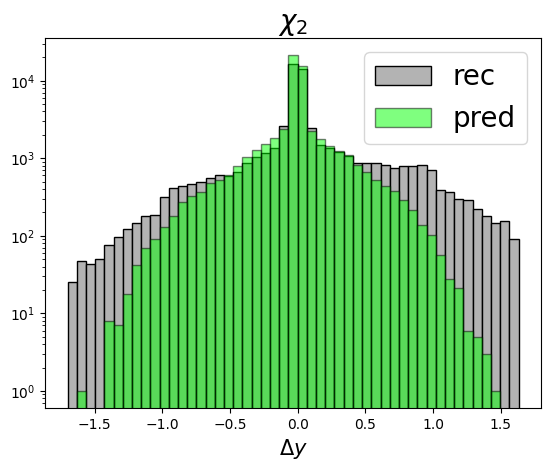

In [18]:
"""
nolatex_names = [ 'm1',   'm2', ' chi1',  'chi2',    'Mc',    'q',  'R_ISCO',     'C']
fmin_vec      = [   -4,     -3,    -1.7,    -1.7,    -1.5,     -4,      -1.7,    -0.5]
fmax_vec      = [    1,      1,     1.7,     1.7,     1.0,    1.2,       0.8,     0.5]
abs_diff_vec  = [False,  False,    True,    True,   False,  False,     False,    True]
logscale_vec  = [False,  False,   False,   False,    True,  False,     False,   False]
"""
if features2use=='mass&spin':
    nolatex_names = [ 'm1',   ' chi1',  'chi2',    'Mc']
    fmin_vec      = [   -4,     -1.7,    -1.7,    -1.5 ]
    fmax_vec      = [    1,      1.7,     1.7,     1.0 ]
    abs_diff_vec  = [False,     True,    True,   False ]
    logscale_vec  = [False,    False,   False,    True ]
else:
    nolatex_names = [ 'm1',   '  m2',  'chi1',   'chi2']
    fmin_vec      = [   -10,     -3.,    -1.7,    -1.7 ]
    fmax_vec      = [    2,      1.7,     1.7,     1.7 ]
    abs_diff_vec  = [False,     False,    True,    True ]
    logscale_vec  = [ True,      True,    True,    True]


for i in range(nfeatures):
    print('-'*(50-len(nolatex_names[i])), nolatex_names[i], '-'*50)
    NN.plot_err_histogram(feature_idx=i, fmin=fmin_vec[i], fmax=fmax_vec[i], verbose=True, 
                          abs_diff=abs_diff_vec[i], name=names[i], show=show_figs, save=save_figs, 
                          logscale=logscale_vec[i], nbins=50)

In [19]:
#test_prediction = NN.compute_prediction(NN.xtest, transform_output=True)
#cnn.write_result('cNN_prediction.csv', test_prediction, verbose=True)

## Other plots 

In [20]:
import importlib
importlib.reload(fp)

<module 'fancyplots' from '/Users/simonealbanesi/repos/IPAM2021_ML/utils/fancyplots.py'>

prediction-time:  0.3370040829999965


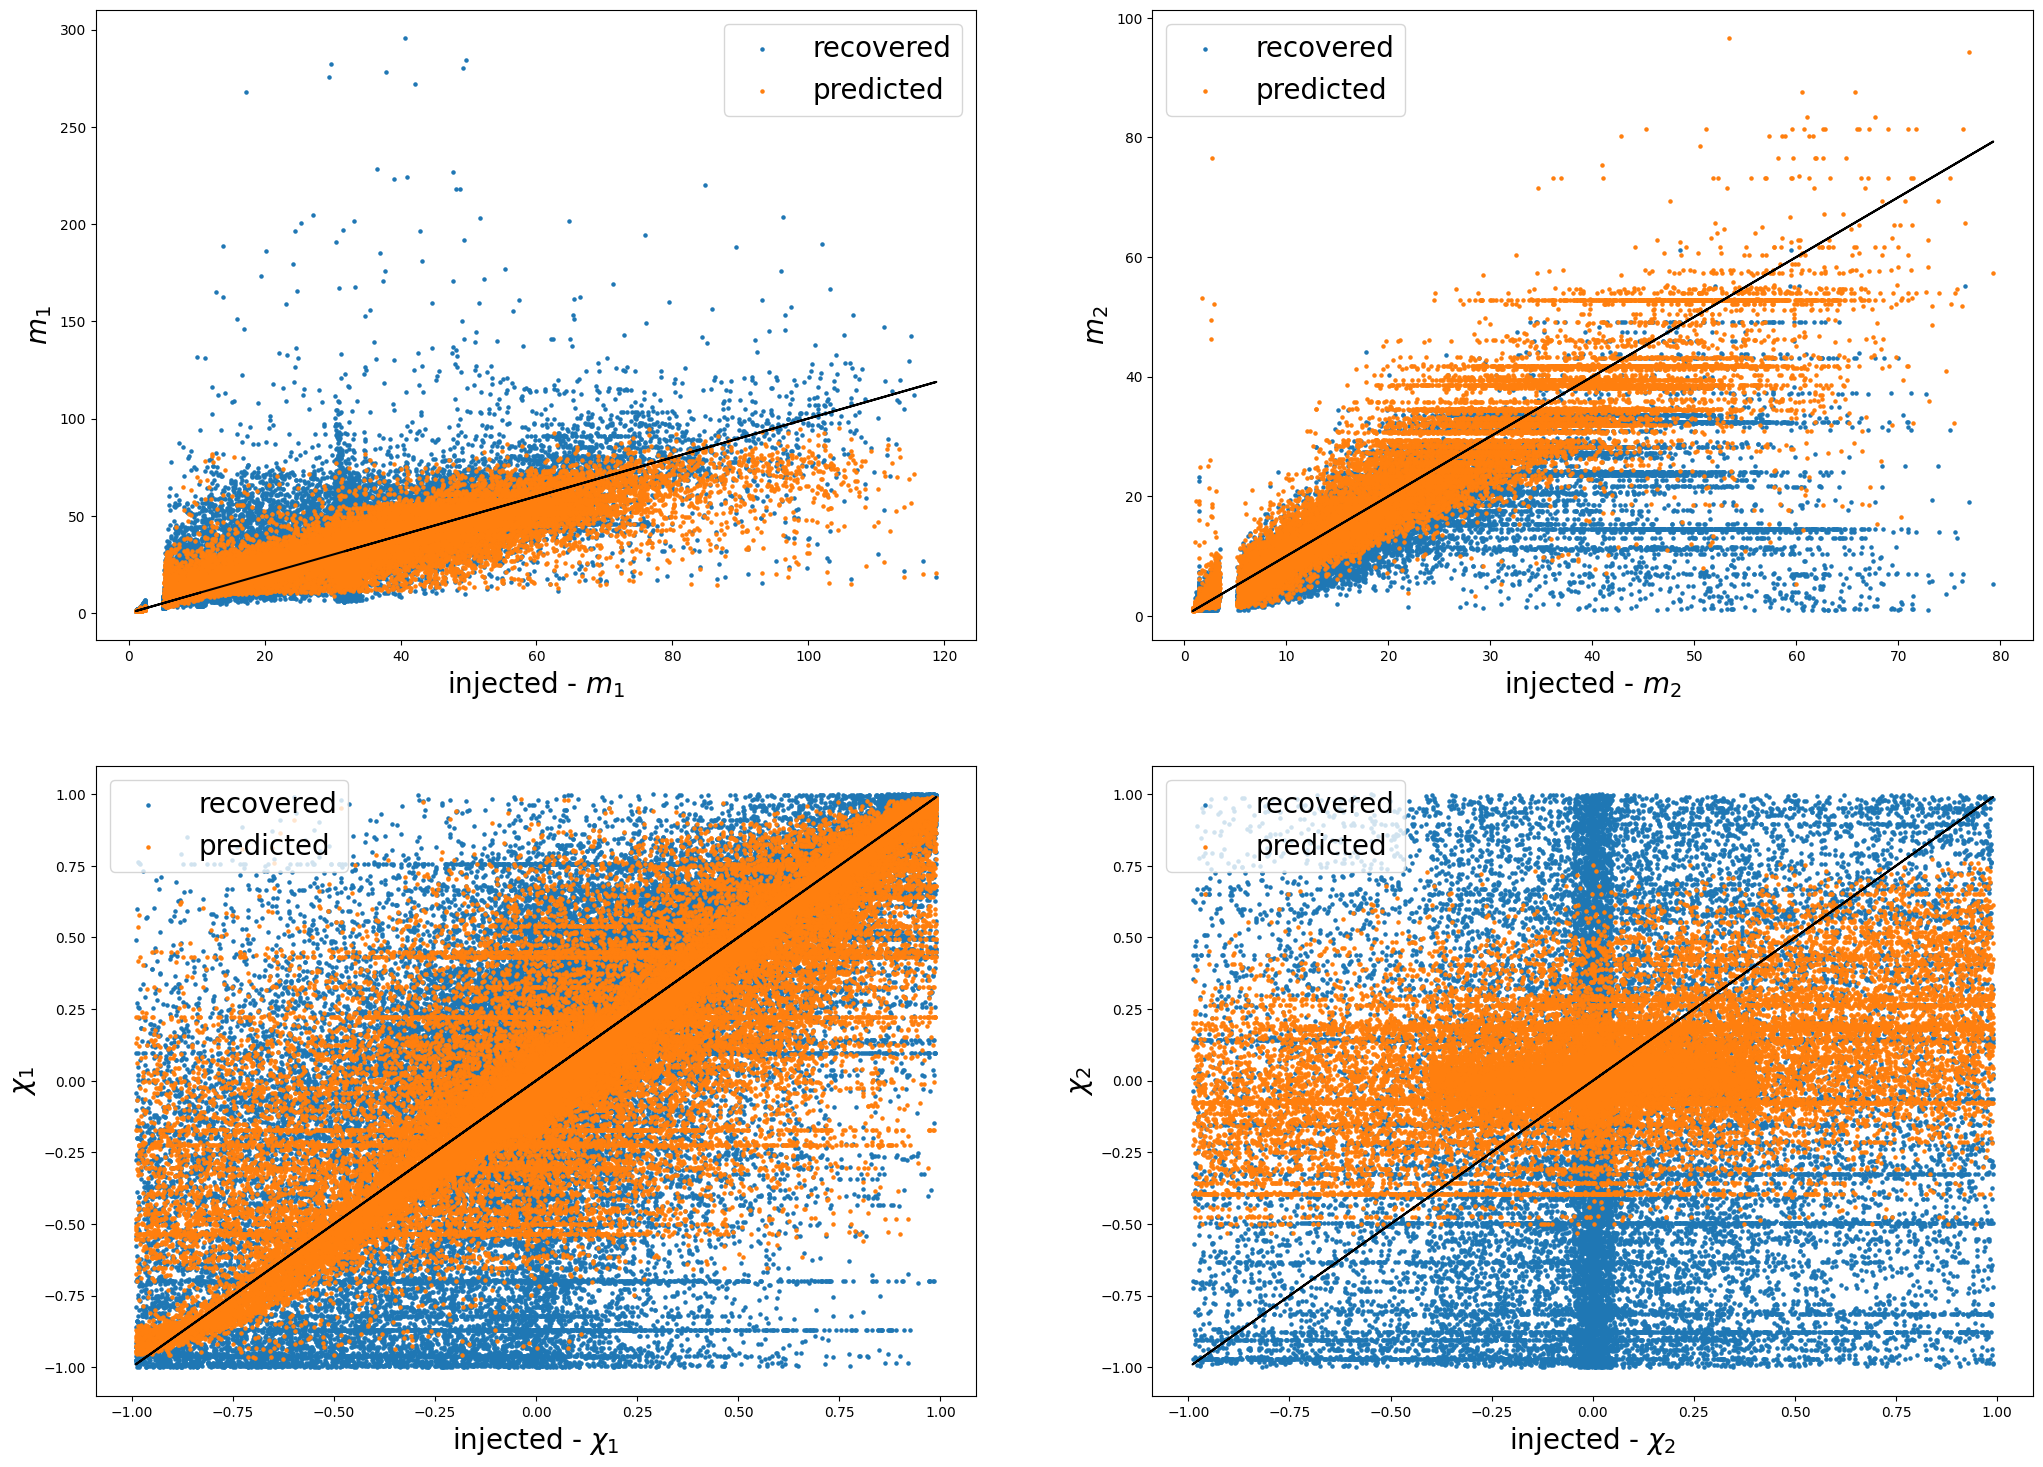

In [21]:
prediction = NN.compute_prediction(NN.xtest, verbose=True) # normalized prediction
fp.checkRegressionPlot(NN.xtest, NN.ytest, prediction, names, 
                              scaler_y=NN.scaler_y, scaler_x=NN.scaler_x, show=show_figs, save=save_figs)

In [22]:
predicted = NN.compute_prediction(NN.xtest, transform_output=True, verbose=True)
injected  = NN.ytest_notnorm
recovered = NN.xtest_notnorm

prediction-time:  0.3606940000000094


In [23]:
# measure comp-time for only one event 
NN.compute_prediction(NN.xtest[0,:], transform_output=True, verbose=True);

prediction-time:  0.001564874999999688


In [24]:
if nfeatures==8:
    m1_pred = predicted[:,0]
    m2_pred = predicted[:,1]
    Mc_pred = predicted[:,4]

    m1_inj  = injected[:,0]
    m2_inj  = injected[:,1]
    Mc_inj  = injected[:,4]

    m1_rec  = recovered[:,0]
    m2_rec  = recovered[:,1]
    Mc_rec  = recovered[:,4]

    def compute_Mc(m1,m2):
        return (m1*m2)**(3/5)/(m1+m2)**(1/5)

    Mc_comp = compute_Mc(m1_pred, m2_pred)

    color_rec  = np.array([0.6,0.6,0.6])
    color_pred = np.array([0,1,0])
    color_comp = np.array([1,0,0])

    plt.figure
    plt.scatter(Mc_inj, Mc_rec , s=1, c=color_rec.reshape(1,-1))
    plt.scatter(Mc_inj, Mc_pred, s=1, c=color_pred.reshape(1,-1))
    plt.scatter(Mc_inj, Mc_comp, s=1, c=color_comp.reshape(1,-1))
    plt.plot(Mc_inj, Mc_inj, c=[0,0,0])
    plt.xlabel(r'$M_c$ - inj', fontsize=15)
    plt.ylabel(r'$M_c$', fontsize=15)
    if save_figs:
        plt.savefig('Mc.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()

    nbins = 31

    errors_rec  = (Mc_inj- Mc_rec )/Mc_inj
    errors_pred = (Mc_inj- Mc_pred)/Mc_inj
    errors_comp = (Mc_inj- Mc_comp)/Mc_inj

    fmin  = -3
    fmax  =  3
    fstep = (fmax-fmin)/nbins

    pred_min_outliers = 0 
    pred_max_outliers = 0 
    for i in range(len(errors_pred)):
        if errors_pred[i]<fmin:
            pred_min_outliers += 1
    for i in range(len(errors_pred)):
        if errors_pred[i]>fmax:
            pred_max_outliers += 1 
    rec_min_outliers = 0 
    rec_max_outliers = 0 
    for i in range(len(errors_rec)):
        if errors_rec[i]<fmin:
            rec_min_outliers += 1
    for i in range(len(errors_rec)):
        if errors_rec[i]>fmax:
            rec_max_outliers += 1 
    comp_min_outliers = 0 
    comp_max_outliers = 0 
    for i in range(len(errors_comp)):
        if errors_comp[i]<fmin:
            comp_min_outliers += 1
    for i in range(len(errors_comp)):
        if errors_comp[i]>fmax:
            comp_max_outliers += 1 

    print('recovery    below fmin={:6.2f}: {:d}'.format(fmin,  rec_min_outliers))
    print('recovery    above fmax={:6.2f}: {:d}'.format(fmax,  rec_max_outliers))
    print('prediction  below fmin={:6.2f}: {:d}'.format(fmin, pred_min_outliers))
    print('prediction  above fmax={:6.2f}: {:d}'.format(fmax, pred_max_outliers))
    print('computation below fmin={:6.2f}: {:d}'.format(fmin, comp_min_outliers))
    print('computation above fmax={:6.2f}: {:d}'.format(fmax, comp_max_outliers))

    plt.figure
    plt.hist(errors_rec , bins=np.arange(fmin, fmax, fstep), alpha=1.0, color=color_rec,  label='rec',
             histtype='bar', ec='black')
    plt.hist(errors_pred, bins=np.arange(fmin, fmax, fstep), alpha=0.7, color=color_pred, label='pred',
             histtype='bar', ec='black')
    plt.hist(errors_comp, bins=np.arange(fmin, fmax, fstep), alpha=0.5, color=color_comp, label='comp',
             histtype='bar', ec='black')
    plt.legend(fontsize=20)
    plt.xlabel(r'$\Delta y/y$', fontsize=15)
    if save_figs:
        plt.savefig('err_hist_Mc.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()

In [25]:
#import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

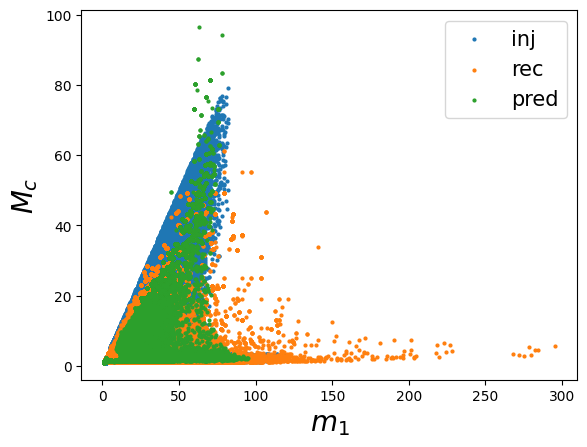

In [26]:
plt.figure
plt.scatter( injected[:,0],  injected[:,1], s=4, label='inj')
plt.scatter(recovered[:,0], recovered[:,1], s=4, label='rec')
plt.scatter(predicted[:,0], predicted[:,1], s=4, label='pred')
plt.xlabel(r'$m_1$', fontsize=20)
plt.ylabel(r'$M_c$', fontsize=20)
plt.legend(fontsize=15)
plt.show()

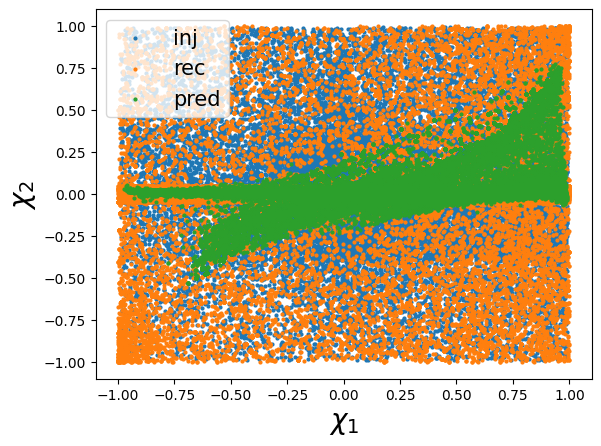

In [27]:
plt.figure
plt.scatter( injected[:,2],  injected[:,3], s=4, label='inj')
plt.scatter(recovered[:,2], recovered[:,3], s=4, label='rec')
plt.scatter(predicted[:,2], predicted[:,3], s=4, label='pred')
plt.xlabel(r'$\chi_1$', fontsize=20)
plt.ylabel(r'$\chi_2$', fontsize=20)
plt.legend(fontsize=15)
plt.show()

## Error statistics

In [28]:
# Note that this is on train-dataset! We need the training-prediction to compute the error-statistic (I think)
predicted = NN.compute_prediction(NN.xtrain, transform_output=True)
injected  = NN.ytrain_notnorm
recovered = NN.xtrain_notnorm

In [29]:
importlib.reload(es)

<module 'errstats' from '/Users/simonealbanesi/repos/IPAM2021_ML/algo/classy_NN/errstats.py'>

In [30]:
n = 3000
if show_err_distr: 
    idx = 3
    print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
    ErrorStats_Mc = es.ErrorStats()
    ErrorStats_Mc.fit(predicted[:,idx],injected[:,idx], n=n, project=True, sigma=5, npoly=[3,3,2])
    ErrorStats_Mc.plot_bins()
    #ErrorStats_Mc.plot_xstep()
    ErrorStats_Mc.plot_moments(plot_poly_fit=True)
    ErrorStats_Mc.plot_stats(plot_xbins=False, show_info=False)
    """
    idx = 2
    print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
    ErrorStats_chi2 = es.ErrorStats()
    ErrorStats_chi2.fit(predicted[:,idx],injected[:,idx], n=n, project=False, sigma=5, npoly=[3,4,1])
    ErrorStats_chi2.plot_bins()
    #ErrorStats_chi2.plot_xstep()
    ErrorStats_chi2.plot_moments(plot_poly_fit=True)
    ErrorStats_chi2.plot_stats(plot_xbins=False, show_info=False)
    
    print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
    ErrorStats_chi2 = es.ErrorStats()
    ErrorStats_chi2.fit(predicted[:,idx],injected[:,idx], n=n, project=True, sigma=5, npoly=[3,4,1])
    ErrorStats_chi2.plot_bins()
    ErrorStats_chi2.plot_moments(plot_poly_fit=True)
    ErrorStats_chi2.plot_stats(plot_xbins=False, show_info=False)
    
    idx = 0
    print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
    ErrorStats_m1 = es.ErrorStats()
    ErrorStats_m1.fit(predicted[:,idx],injected[:,idx], n=n, project=False, sigma=5, npoly=[3,2,1])
    ErrorStats_m1.plot_bins()
    ErrorStats_chi2.plot_moments(plot_poly_fit=True)
    ErrorStats_m1.plot_stats(plot_xbins=False, show_info=False)
    """;

## New method to estimate errors

In [31]:
if show_errsurf:
    importlib.reload(errsurf)

    feature_names = ['m1', 'chi1', 'chi2', 'Mc']

    x0_list         = {}
    x0_list['m1']   = [2, 10, 31.5]
    x0_list['chi1'] = [-0.9,0,0.9]
    x0_list['chi2'] = [-0.3,0,0.5]
    x0_list['Mc']   = [2,8,20,60]
    exp_step_vec    = [True, False, False, True]
    log_scale_vec   = [True, False, False, True]
    esurf_list = []
    for i in range(len(feature_names)):
        f = feature_names[i]
        print('\n', '#'*100, ' '*48+f, '#'*100, sep='\n')
        esurf = errsurf.ErrorSurface(predicted[:,i], injected[:,i], Nx=50, Ny=50, 
                                        exp_step=exp_step_vec[i], dx_expstep=1.05, dy_expstep=1.05,
                                        method='linear', Nx_grid=1000, Ny_grid=1000)
        esurf.plot_surf(log_scale=log_scale_vec[i], log_bar=True)
        if log_scale_vec[i]:
            esurf.plot_surf(log_scale=False, log_bar=True)
        nbins   = 40
        for x0 in x0_list[f]:
            print('-'*100, ' '*42+f+': '+str(x0), '-'*100, sep='\n')
            esurf.plot_interp(x0_line=x0, log_scale=False, log_bar=True)
            esurf.plot_hist(x0, nbins=nbins)
        esurf_list.append(esurf)

In [32]:
if show_errsurf:
    importlib.reload(errsurf)

    idx = 0
    nbins_vec = [10, 50, 100]
    x0 = 20

    for nbins in nbins_vec:
        xl, xr, cfi_final = esurf_list[idx].confidence_interval(x0, cfi=0.90, verbose=True, nbins=nbins, 
                                                      spline=True, spline_sample=1000, spline_plot=True)
        esurf_list[idx].plot_hist(x0, nbins=nbins, axvlines=[xl, xr])
        print('[{:f},{:f}] -> {:f}'.format(xl, xr, cfi_final))

## Compare prediction and recovery for m1

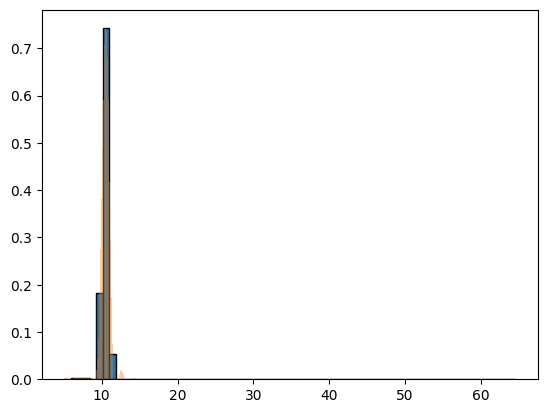

----------------------------------------------------------------------------------------------------
cfi requested                  : 0.900000
number of bins                 : 999
left-idf, right-idx            : 79, 102
left-tail prob, left-tail prob : 0.05800, 0.06431
final cfi (diff from initial)  : 0.87769 (-2.478946 %)
sum of final cfi and compl-cfi : 1.0000000000
----------------------------------------------------------------------------------------------------
prediction, 90% interval: 10.00, [9.76,11.13]


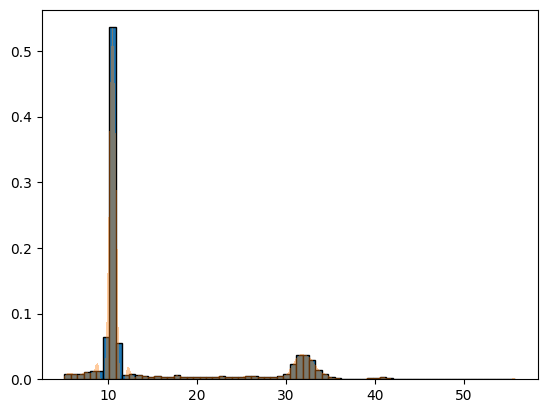

----------------------------------------------------------------------------------------------------
cfi requested                  : 0.900000
number of bins                 : 999
left-idf, right-idx            : 73, 550
left-tail prob, left-tail prob : 0.05036, 0.05183
final cfi (diff from initial)  : 0.89782 (-0.242395 %)
sum of final cfi and compl-cfi : 1.0000000000
----------------------------------------------------------------------------------------------------
prediction, 90% interval: 10.00, [8.76,32.98]


In [33]:
idx = 0
esurf_pred = errsurf.ErrorSurface(predicted[:,idx], injected[:,idx], exp_step=True, dx_expstep=1.05, dy_expstep=1.05,
                                  method='linear', Nx_grid=1000, Ny_grid=1000)
esurf_rec = errsurf.ErrorSurface(recovered[:,idx], injected[:,idx], exp_step=True, dx_expstep=1.05, dy_expstep=1.05,
                                  method='linear', Nx_grid=1000, Ny_grid=1000)

x0  = 10

# prediction
xl, xr, cfi_final = esurf_pred.confidence_interval(x0, cfi=0.90, verbose=True, nbins=70, 
                                                        spline=True, spline_sample=1000, spline_plot=True)
print('prediction, 90% interval: {:.2f}, [{:.2f},{:.2f}]'.format(x0,xl,xr))

# recovery
xl, xr, cfi_final = esurf_rec.confidence_interval(x0, cfi=0.90, verbose=True, nbins=70, 
                                                        spline=True, spline_sample=1000, spline_plot=True)
print('prediction, 90% interval: {:.2f}, [{:.2f},{:.2f}]'.format(x0,xl,xr))

## Cross-validation

In [34]:
if do_crossval:
    dict_name = 'crossval_dicts/GstLAL_sk.dict'

    train_inj = train_data_split['inj']
    train_rec = train_data_split['rec']
    test_inj  = test_data_split['inj']
    test_rec  = test_data_split['rec']

    CV = sknn.CrossValidator(neurons_max=750, neurons_step=50, dict_name=dict_name,
                            xtrain=train_rec, ytrain=train_inj, xtest=test_rec, ytest=test_inj,
                            epochs=100, batch_size=128, seed=None,
                            compact_bounds=compact_bounds)
    CV.crossval(verbose=False)

    for i in range(-1,nfeatures):
        CV.plot(feature_idx=i, threshold=None)